In [16]:
## LSTM neural network part 2 (optional)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Neural network
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#Preprocessing
import pandas as pd
from pandas import Series
import numpy as np
import os
from sklearn.model_selection import train_test_split

#visualization 
import matplotlib.pyplot as plt

In [18]:
#Import the airline passengers data

def closePrice(filename):
    data = pd.read_csv(filename, sep = ",", header = 1)
    data = data[['date', 'close']].set_index(['date'])
    return data[:1421][::-1]

bitcoin = closePrice("Binance_BTCUSDT_d.csv")
ethereum = closePrice("Binance_ETHUSDT_d.csv")
binance = closePrice("Binance_BNBUSDT_d.csv")
cardano = closePrice("Binance_ADAUSDT_d (2).csv")
solana = closePrice("Binance_SOLUSDT_d.csv")
ripple = closePrice("Binance_XRPUSDT_d.csv")
print(ripple.isna().sum())

close    0
dtype: int64


In [37]:
# Define coin names for functions later on
coins = [bitcoin, ethereum, binance, cardano, solana, ripple]
coin_name = ['Bitcoin', 'Ethereum', "Binance coin", "Cardano", "Solana", "Ripple"]
coin_abr = ["BTC", "ETH", "BNB", "ADA", "SOL", "XRP"]


In [ ]:
# visualizations
for i,coin in enumerate(coins):
    plt.subplot(2,3,i+1), plt.plot(coin), plt.title("Plot of " + coin_name[i] + " Dec. 2017 - Oct. 2022")
    

In [255]:
# Convert to numpy arrray
data = ripple.to_numpy()

# scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

sequence = scaler.fit_transform(data.reshape(-1,1))
print(sequence[:10], sequence.shape)

[[0.44398213]
 [0.45157399]
 [0.42922804]
 [0.40572861]
 [0.39499997]
 [0.38802017]
 [0.35904755]
 [0.31815748]
 [0.32352474]
 [0.34987259]] (1307, 1)


### Training data and test data division

In [256]:
training_size = int(len(sequence) * 0.85) # 85% of data used for training
test_size = len(sequence) - training_size

print(training_size, test_size)
train_data, test_data = sequence[0:training_size, :], sequence[training_size:len(sequence), :]

1110 197


In [257]:
train_data.shape, test_data.shape

((1110, 1), (197, 1))

### convert time series into matrix

In [258]:
def create_dataset(sequence, timestep =1):
    dataX, dataY = [], []
    for i in range(len(sequence) - timestep -1):
        a = sequence[i:(i +timestep), 0]
        dataX.append(a)
        dataY.append(sequence[i + timestep, 0])
    return np.array(dataX), np.array(dataY)

In [259]:
# reshape into X=t, X=t+1, X=t+2, X=t+3

timestep = 3
X_train, y_train = create_dataset(train_data, timestep)
X_test, y_test = create_dataset(test_data, timestep)

In [260]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1106, 3) (1106,)
(193, 3) (193,)


In [261]:
# reshape input to be [samples, timesteps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [262]:
# Build the model

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(timestep,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'root_mean_squared_error', optimizer = "adam")


In [263]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 3, 50)             10400     
_________________________________________________________________
lstm_52 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
lstm_53 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [264]:
## fit the model

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 2, verbose = 1, workers = 4)

Epoch 1/50
553/553 [==============================] - 16s 12ms/step - loss: 0.0048 - val_loss: 0.0115
Epoch 2/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 3/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 4/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 5/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 6/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 7/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 8/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/50
553/553 [==============================] - 3s 5ms/step - loss: 0.0010 - val_loss: 0.00

In [265]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
test_pred[:5], train_pred[:5]

(array([[0.6421966 ],
        [0.5268387 ],
        [0.47441554],
        [0.3962027 ],
        [0.5142768 ]], dtype=float32),
 array([[0.43231177],
        [0.41061935],
        [0.39823014],
        [0.38868502],
        [0.35828036]], dtype=float32))

In [266]:
# transform data back to normal scale
train_predictions= scaler.inverse_transform(train_pred)
test_predictions = scaler.inverse_transform(test_pred)
test_predictions[:5], train_predictions[:5]

(array([[1.2267041],
        [1.0306891],
        [0.9416122],
        [0.8087137],
        [1.0093441]], dtype=float32),
 array([[0.87006986],
        [0.8332103 ],
        [0.81215864],
        [0.7959397 ],
        [0.7442764 ]], dtype=float32))

In [267]:
model.evaluate(X_test, test_pred, batch_size = 10)

20/20 [==============================] - 3s 3ms/step - loss: 9.9402e-16


9.940235509099042e-16

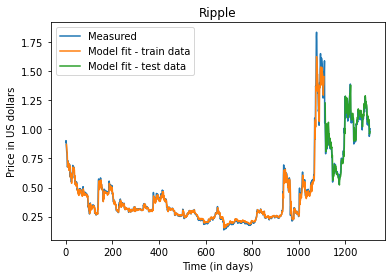

In [269]:
## Plotting 
# shift trainpredictions for plotting

look_back = timestep
trainPredictPlot = np.empty_like(sequence)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predictions) + look_back, :] = train_predictions
#  shift test preds for plotting

testPredictPlot = np.empty_like(sequence)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predictions) + (look_back * 2) + 1: len(sequence) -1, :] = test_predictions


#plot baseline and predictions
plt.plot(scaler.inverse_transform(sequence), label = "Measured")
plt.plot(trainPredictPlot, label = "Model fit - train data")
plt.plot(testPredictPlot, label = "Model fit - test data")
plt.xlabel("Time (in days)"), plt.ylabel("Price in US dollars"), plt.title("Ripple")
plt.legend()

In [64]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split



# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


regr = MLPRegressor(hidden_layer_sizes = (100), activation = 'relu', random_state=42, max_iter=500).fit(X_train, y_train)
y_pred = regr.predict(X_test)

regr.score(X_test, y_test)

0.9400193799329098

In [66]:
mean_squared_error(y_test, y_pred, squared = False)

0.07671010397213307